# Segmentation: segmenting images and cropping coins

In this section, we want to segment part of the image that correspond to coins. To do so, we chose to detect circular regions using the Hough transform. 

## 1. Preprocessing the image

Here, we describe the preprocessing steps required to properly extract the coins in noisy background.

### 1.1 Resize the image

First, we have to reduce the image's size to make the pipeline computationaly sustainable. Preprocessing operations, especially morphology, take more than ten minutes on a single image. 

Further, an image with size reduced by a factor of 10 still allows to accurately detect the coins while decreasing computation time.

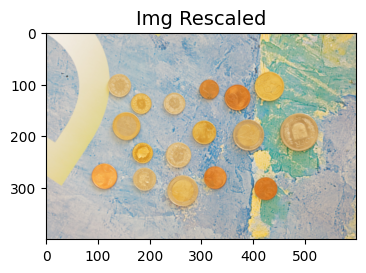

In [2]:
import cv2

from scripts.preprocessing import read_image_from_path
from scripts.viz import plot_images

filepath = 'train/L1010370.JPG'

# Preprocess rescaled image
img_rescaled = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=True)

plot_images(
	img_rescaled=img_rescaled
)


### 1.2 Contrast, morphology and Sobel filter

We select which operations we want to apply to preprocess the reduced image by listing them in the  `operation_list` list, to select the desired operations and their orders from the `operation_dict` dictionary.

In [3]:
from scripts.preprocessing import (apply_opening, apply_sobel, apply_hsv_threshold, adjust_contrast, apply_erosion, apply_dilation, apply_black_tophat, apply_white_tophat ) 

operation_dict = {'opening': apply_opening,
	'sobel': apply_sobel,
	'threshold': apply_hsv_threshold,
	'contrast': adjust_contrast,
	'erosion': apply_erosion,
	'dilation': apply_dilation,
	'blackth': apply_black_tophat,
	'whiteth': apply_white_tophat
	}

Here, from the resized image, we need to successively apply:
1. Contrast enhancement
2. Opening with a small disk to remove small holes
3. Thresholding
4. Sobel filter to enhance edges

These preprocessing steps are necessary to allow a proper detection of circular regions, which we do using the Hough transform (`apply_hough`) with hand tuned parameters obtained through experiments.

Without these additional steps, the segmentation fails with noisy background or coins held in a hand. However, there are cases where some coins are still not properly recognized.

In [4]:
operation_list = ['contrast', 'opening', 'threshold', 'sobel']

### 1.3 Hough circles on the reduced image

The `apply_operation` allows to quickly experimenting combinations of operations. We found that the afore mentioned list gives the best results.

From the reduced image we show here each image after the corresponding preprocessing operation.

The last operation consists of applying the Hough transform to obtain the coordinates and radius of circles shown in green. Overlapping circles are filtered out by keeping only the biggest circles.

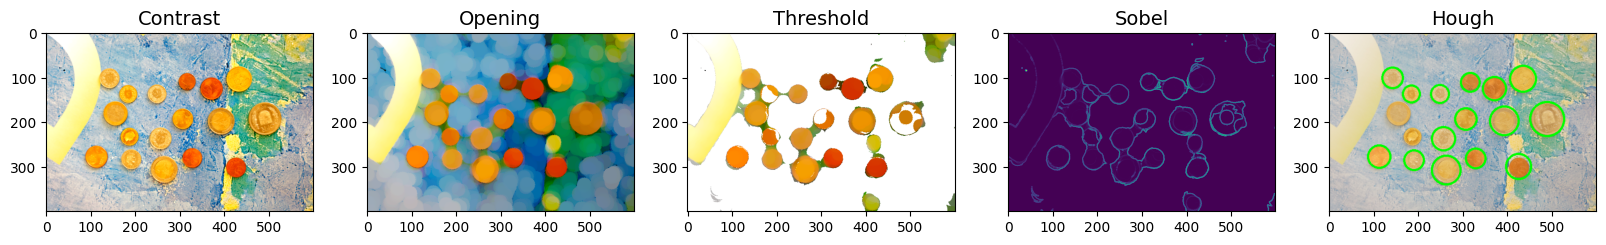

In [5]:
from scripts.preprocessing import (apply_operation, get_hough_circles, scale_hough_circles, apply_hough)

output_list = apply_operation(img_rescaled, operation_list, operation_dict)

# Hough transform on last item and add to list
hough = apply_hough(output_list[-1], img_rescaled)
output_list.append(hough)

# Zip for plot
img_dict = dict(zip(operation_list + ['hough'], output_list))

plot_images(
**img_dict
)

## 2. Rescaling the Hough circles

As a last step, we obtain the correct location of the circular region on the original image by simply rescaling the circles coordinates and radius to match the original picture ratio.

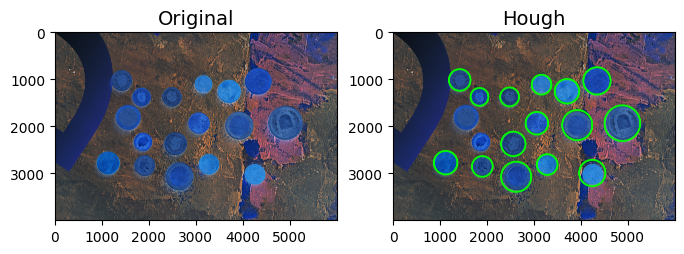

In [6]:
ratio = 10

output_list = apply_operation(img_rescaled, operation_list, operation_dict)

# Get circles and rescale to original image size
hough_circles = get_hough_circles(output_list[-1], img_rescaled)
hough_circles_rescaled = scale_hough_circles(hough_circles, ratio, 0, 0)

# Plot original image with rescaled circles
img_original = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=False)
img_original_hough = img_original.copy()

for (x,y,r) in hough_circles_rescaled:
	cv2.circle(img_original_hough, (x,y), r, (0,255,0), 40)

plot_images(
	original=img_original,
	hough=img_original_hough
)

Once the correct location is marked, we crop each region centered at the rescaled Hough circle location to segment the coin.

# Description: extracting image descriptors from cropped coin images

Now that the coins are segmented, we need to extract meaningful information on the image content. We choose several descriptors that we manually compute for each image to build a dataset used for classification.

## 1. Descriptors extraction

In this section, we build the dataset made up of the different descriptors.

### 1.1 Imports



In [7]:
import json
import os

import numpy as np
import pandas as pd

from tqdm import tqdm

from skimage import io
from skimage.color import convert_colorspace

from scripts.descriptors import descr_mean, descr_std, descr_img_smoothness, descr_hog, descr_mean_annulus, descr_std_annulus, descr_mean_center, descr_std_center, descr_histogram_tuple_diff

### 1.2 Parameters

In [62]:
train_dir = 'classification'
df_dir = 'dataset_df'

ratio = 10
max_width = 4000
max_height = 6000

# Open JSON file with filepath and img class
json_filename = 'classification/labels.json'
f = open(json_filename)
json_data = json.load(f)

img_class = json_data.values()
img_filename = json_data.keys()

# Prepare dataframes
X_dataset = pd.DataFrame()
y_dataset = pd.DataFrame()

### 1.3 Dataset building loop

We build the dataset used for classification by extracting descriptors from segmented coin images.

In [63]:
i = 0
# Iterate over file listed in JSON
for (img_f, img_c) in tqdm(zip(img_filename, img_class)):
	if i>1:
		break
	# Open img without rescaling
	filepath = os.path.join(train_dir, img_f)
	img_extract = io.imread(filepath)

	# Descriptor : radius
	radius = np.mean(img_extract.shape[0:2]) / 2

	# Descriptor : mean and SD of colour histogram for whole image
	mean_rgb = descr_mean(img_extract)
	mean_hsv = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
	mean_yuv = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

	std_rgb = descr_std(img_extract)
	std_hsv = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
	std_yuv = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

	# Descriptor : smoothness of image
	smoothness = descr_img_smoothness(img_extract)

	# Descriptor : Histogram of Oriented Gradients
	fd, hog_image = descr_hog(img_extract, 500, 500, True)
	hog_image = hog_image.flatten().tolist()

	# Descriptor : mean of colour histogram for regions of interest
	mean_annulus_rgb = descr_mean_annulus(img_extract)
	mean_annulus_hsv = descr_mean_annulus(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
	mean_annulus_yuv = descr_mean_annulus(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))
	
	mean_center_rgb = descr_mean_center(img_extract)
	mean_center_hsv = descr_mean_center(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
	mean_center_yuv = descr_mean_center(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))
	
	# Descriptor : SD of colour histogram for regions of interest
	std_annulus_rgb = descr_std_annulus(img_extract)
	std_annulus_hsv = descr_std_annulus(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
	std_annulus_yuv = descr_std_annulus(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

	std_center_rgb = descr_std_center(img_extract)
	std_center_hsv = descr_std_center(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
	std_center_yuv = descr_std_center(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

	# Descriptor : difference of mean between the two ROI
	mean_diff_roi_rgb = descr_histogram_tuple_diff(mean_annulus_rgb, mean_center_rgb)
	mean_diff_roi_hsv = descr_histogram_tuple_diff(mean_annulus_hsv, mean_center_hsv)
	mean_diff_roi_yuv = descr_histogram_tuple_diff(mean_annulus_yuv, mean_center_yuv)

	# Descriptor : difference of SD between the two ROI
	std_diff_roi_rgb = descr_histogram_tuple_diff(std_annulus_rgb, std_center_rgb)
	std_diff_roi_hsv = descr_histogram_tuple_diff(std_annulus_hsv, std_center_hsv)
	std_diff_roi_yuv = descr_histogram_tuple_diff(std_annulus_yuv, std_center_yuv)


	# Pass each set of descriptors as a dict
	descriptors = {'radius':radius,
		'mean_rgb':mean_rgb,
		'mean_hsv':mean_hsv,
		'mean_yuv':mean_yuv,
		'std_rgb':std_rgb,
		'std_hsv':std_hsv,
		'std_yuv':std_yuv,
		'mean_annulus_rgb': mean_annulus_rgb,
		'mean_center_rgb': mean_center_rgb,
		'mean_annulus_hsv': mean_annulus_hsv,
		'mean_center_hsv': mean_center_hsv,
		'mean_annulus_yuv' : mean_annulus_yuv,
		'mean_center_yuv': mean_center_yuv,
		'std_annulus_rgb': std_annulus_rgb,
		'std_center_rgb': std_center_rgb,
		'std_annulus_hsv': std_annulus_hsv,
		'std_center_hsv': std_center_hsv,
		'std_annulus_yuv': std_annulus_yuv,
		'std_center_yuv': std_center_yuv,
		'mean_diff_roi_rgb': mean_diff_roi_rgb,
		'std_diff_roi_rgb': std_diff_roi_rgb,
		'mean_diff_roi_hsv': mean_diff_roi_hsv,
		'std_diff_roi_hsv': std_diff_roi_hsv,
		'mean_diff_roi_yuv': mean_diff_roi_yuv,
		'std_diff_roi_yuv': std_diff_roi_yuv,
		'smoothness':smoothness,
		'hog':hog_image
		}
	label = {'label': img_c}

	# Add to dataset
	X_dataset = X_dataset._append(descriptors, ignore_index=True)
	y_dataset = y_dataset._append(label, ignore_index=True)
	i+=1
	
	# Save dataset for current file
	#df_filename = f"{filename}_DF.csv"
	#df.to_csv(path_or_buf=os.path.join(df_dir, df_filename))

0it [00:00, ?it/s]

2it [00:05,  2.62s/it]


### 1.4 (Optional) Saving dataset to CSV

In [ ]:
X_train.to_csv('classification/xtrain.csv', sep=',', index=False, encoding='utf-8')
y_train.to_csv('classification/ytrain.csv', sep=',', index=False, encoding='utf-8')

## 2. Descriptors showcase

### 2.1 Showcase on two coin types

To illustrate how descriptors can be used to discriminate coin types, we will focus on two types coins: the 5CHF and 2EUR coins.

The two coins are scaled on the plot after this to appear with the same size, however, their real size is not changed when performing descriptor computation. 

In [13]:
from scripts.viz import plot_images

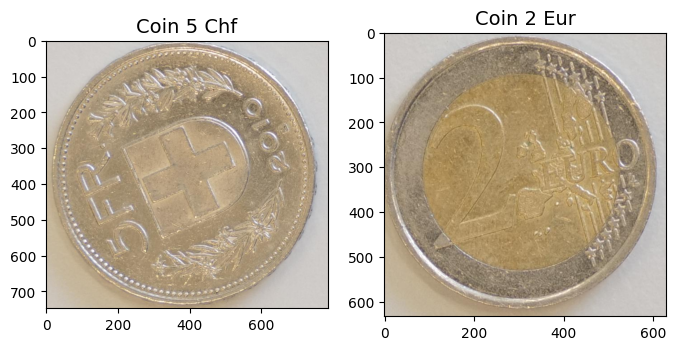

In [14]:
coin_5chf_filename = 'L1010277_cropped_1.jpg'
coin_2eur_filename = 'L1010277_cropped_2.jpg'

# Open img without rescaling
filepath_5chf = os.path.join(train_dir, coin_5chf_filename)
filepath_2eur = os.path.join(train_dir, coin_2eur_filename)

img_5chf = io.imread(filepath_5chf)
img_2eur = io.imread(filepath_2eur)

plot_images(coin_5_chf=img_5chf,
	    coin_2_eur=img_2eur)

We extract all the 5CHF and 2EUR coins using their labels:
- Label 0 is for 5CHF
- Label 7 is for 2EUR

Both sides (tail or head) are included.

In [15]:
all_2eur = X_dataset[y_dataset['label'] == 7]
all_5chf = X_dataset[y_dataset['label'] == 0]

### 2.2 Mean and Standard deviation in different colourspaces

A discriminatory factor between coins is their colour distributions. For example, distribution of a fairly uniformly coloured coin (typically, a 5 CHF coin) should be different from that of a coin with two distinct bands (typically, the 2 EUR coins built with two differently colourd regions, the central circular region and the exterior annulus).

Further, the materials give coins distinct colours (silver and zinc) that could be used to serve as a descriptor to discriminate coins.

Finally, these descriptors are invariant to geometrical transformation since mean and standard deviation do not depend on coin orientation.

We extract these informations by computing mean and standard deviation of each channels for the whole cropped image. The operation is repeated for several colourspaces (RGB, HSV, YUV).

In [16]:
import matplotlib.pyplot as plt

In [17]:
mean_red_2eur = all_2eur['mean_rgb'].apply(lambda x: x[0])
mean_green_2eur = all_2eur['mean_rgb'].apply(lambda x: x[1])
mean_blue_2eur = all_2eur['mean_rgb'].apply(lambda x: x[2])

mean_red_5chf = all_5chf['mean_rgb'].apply(lambda x: x[0])
mean_green_5chf = all_5chf['mean_rgb'].apply(lambda x: x[1])
mean_blue_5chf = all_5chf['mean_rgb'].apply(lambda x: x[2])

sd_red_2eur = all_2eur['std_rgb'].apply(lambda x: x[0])
sd_green_2eur = all_2eur['std_rgb'].apply(lambda x: x[1])
sd_blue_2eur = all_2eur['std_rgb'].apply(lambda x: x[2])

sd_red_5chf = all_5chf['std_rgb'].apply(lambda x: x[0])
sd_green_5chf = all_5chf['std_rgb'].apply(lambda x: x[1])
sd_blue_5chf = all_5chf['std_rgb'].apply(lambda x: x[2])

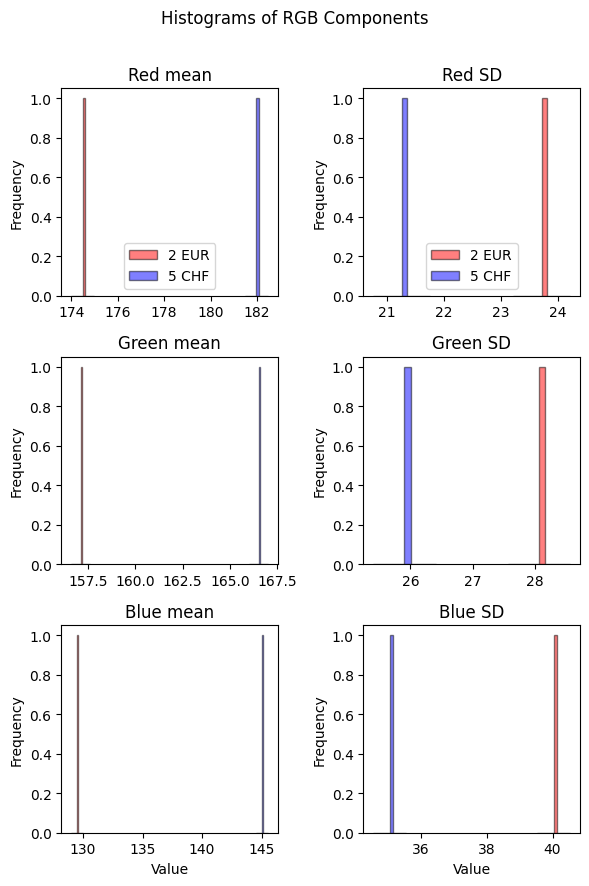

In [18]:
# Plotting
fig, axs = plt.subplots(3, 2, figsize=(6, 9), sharex=False)

# Red mean
axs[0,0].hist(mean_red_2eur, bins=10, alpha=0.5, color='red', edgecolor='black', label='2 EUR')
axs[0,0].hist(mean_red_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black', label='5 CHF')
axs[0,0].set_title('Red mean')
axs[0,0].set_ylabel('Frequency')
axs[0,0].legend()

# Green mean
axs[1,0].hist(mean_green_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[1,0].hist(mean_green_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[1,0].set_title('Green mean')
axs[1,0].set_ylabel('Frequency')

# Blue mean
axs[2,0].hist(mean_blue_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[2,0].hist(mean_blue_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[2,0].set_title('Blue mean')
axs[2,0].set_xlabel('Value')
axs[2,0].set_ylabel('Frequency')

# Red SD
axs[0,1].hist(sd_red_2eur, bins=10, alpha=0.5, color='red', edgecolor='black', label='2 EUR')
axs[0,1].hist(sd_red_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black', label='5 CHF')
axs[0,1].set_title('Red SD')
axs[0,1].set_ylabel('Frequency')
axs[0,1].legend()
# Green SD
axs[1,1].hist(sd_green_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[1,1].hist(sd_green_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[1,1].set_title('Green SD')
axs[1,1].set_ylabel('Frequency')

# Blue SD
axs[2,1].hist(sd_blue_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[2,1].hist(sd_blue_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[2,1].set_title('Blue SD')
axs[2,1].set_xlabel('Value')
axs[2,1].set_ylabel('Frequency')

# Main title
fig.suptitle('Histograms of RGB Components')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show plot
plt.show()

The histogram for mean and standard deviation doesn't immediately show a clear separability but might still be useful to the model.

### 2.3 Coin radii

We extract an estimate of the coin radius by computing the mean of the half-width and half-length of the cropped image.

The example for the 2EUR and 5CHF shows that this descriptor is certainly valid to help discriminate coins based on their size.

In [19]:
import matplotlib.pyplot as plt

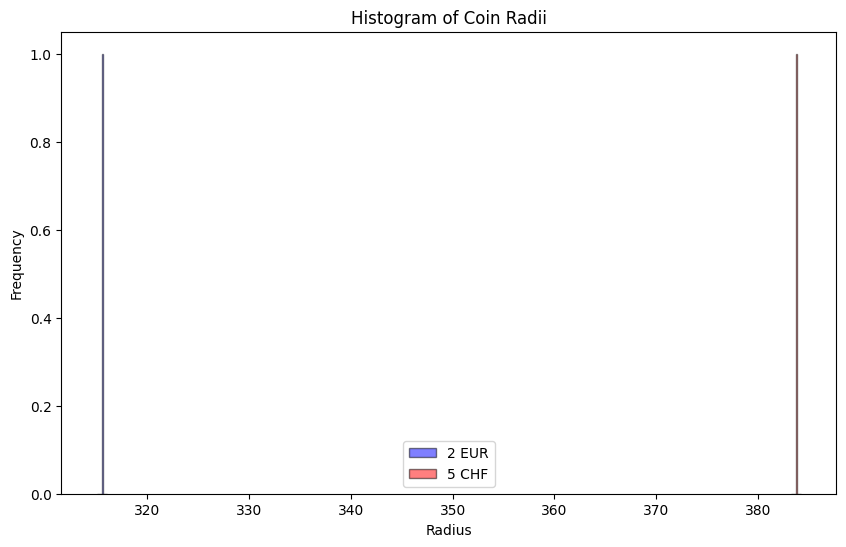

In [20]:
# Plotting
plt.figure(figsize=(10, 6))

plt.hist(all_2eur['radius'], bins=10, alpha=0.5, label='2 EUR', color='blue', edgecolor='black')
plt.hist(all_5chf['radius'], bins=10, alpha=0.5, label='5 CHF', color='red', edgecolor='black')

plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Histogram of Coin Radii')
plt.legend()

# Show plot
plt.show()

There are clearly two modes in the distribution of radii.

### 2.4 Image smoothness

Image smoothness is taken as the averaged absolute value of an image Laplacian, computing the second derivative.

This descriptor should be invariant to geometrical transformations.

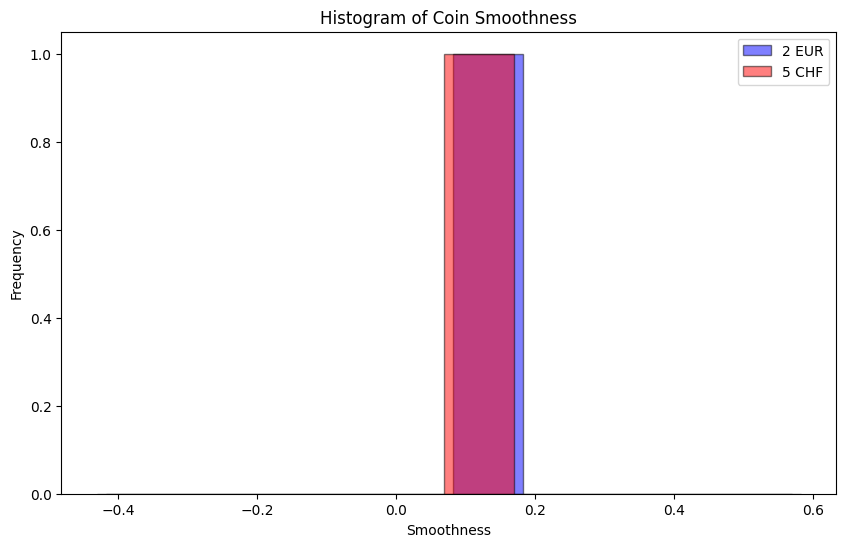

In [21]:
# Plotting
plt.figure(figsize=(10, 6))

plt.hist(all_2eur['smoothness'], bins=10, alpha=0.5, label='2 EUR', color='blue', edgecolor='black')
plt.hist(all_5chf['smoothness'], bins=10, alpha=0.5, label='5 CHF', color='red', edgecolor='black')

plt.xlabel('Smoothness')
plt.ylabel('Frequency')
plt.title('Histogram of Coin Smoothness')
plt.legend()

# Show plot
plt.show()

The two distribution modes should correspond to the smoothness on each of the coin side. Since labelling did not include the coin side, we tested this on a small sample of coins and verified experimentally that smoothness was different depending on the coin side.

However, this feature might not be useful given that there are two modes for a single coin type.

### 2.5 Histogram of Oriented Gradients

Histogram of Oriented Gradients could be useful to extract the information on the coins' textures, but this descriptor is not invariant to rotation. Since the coins are not aligned to a fixed angle, two identical but rotated coins will provide different results.

However, it can provide meaningful information on the global coin texture, which might still be of use.

Text(0.5, 1.0, '2EUR HOG')

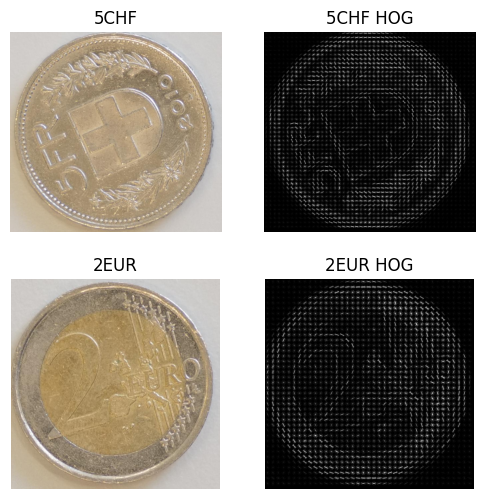

In [24]:
from skimage.feature import hog
from skimage import exposure

# Compute HOG
fd_5chf, hog_5chf = descr_hog(img_5chf, 500, 500, False)
fd_2eur, hog_2eur = descr_hog(img_2eur, 500, 500, False)

# Rescale histogram for better display
hog_5chf_rescaled = exposure.rescale_intensity(hog_5chf, in_range=(0, 10))
hog_2eur_rescaled = exposure.rescale_intensity(hog_2eur, in_range=(0, 10))

fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex=False)


axs[0,0].axis('off')
axs[0,0].imshow(img_5chf, cmap=plt.cm.gray)
axs[0,0].set_title('5CHF')

axs[1,0].axis('off')
axs[1,0].imshow(img_2eur, cmap=plt.cm.gray)
axs[1,0].set_title('2EUR')

axs[0,1].axis('off')
axs[0,1].imshow(hog_5chf_rescaled, cmap=plt.cm.gray)
axs[0,1].set_title('5CHF HOG')

axs[1,1].axis('off')
axs[1,1].imshow(hog_2eur_rescaled, cmap=plt.cm.gray)
axs[1,1].set_title('2EUR HOG')

### 2.6 Radial histograms

We extract the colour histogram of coins on a certain region. Starting from the image center, we build concentric circular regions to separate the central circular region from the exterior annulus.

The color difference between central region and external annulus gives an important information on the coin type. For homogeneous coloured coins, the difference is close to null. For 1 EUR coins and 2 EUR coins, the colours on the central and circular regions are opposed, so should the difference of colours, which could be helpful to classify coins.

Here we extract the center and exterior annulus of a 2 EUR coin:

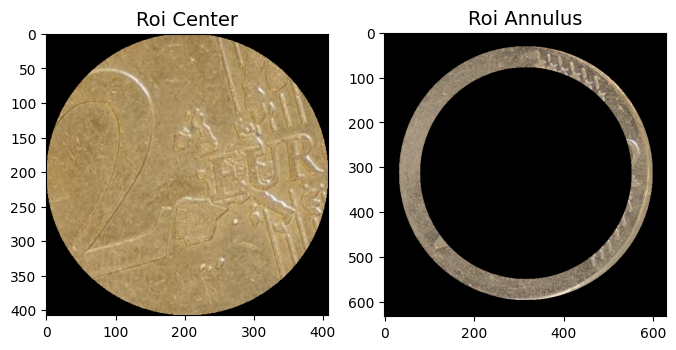

In [25]:
from scripts.descr_preprocessing import extract_annulus_region_by_proportion, extract_center_region_by_proportion

roi_annulus = extract_annulus_region_by_proportion(img_2eur)
roi_center = extract_center_region_by_proportion(img_2eur)

plot_images(roi_center=roi_center,
	    roi_annulus=roi_annulus)

Each of the following plot contain the distribution of differences between the mean/SD of the coin's center and exterior annulus.

We would expect a near zero difference for CHF coins and a significant difference for 1 EUR and 2 EUR coins.

In [26]:
mean_red_diff_2eur = all_2eur['mean_diff_roi_rgb'].apply(lambda x: x[0])
mean_green_diff_2eur = all_2eur['mean_diff_roi_rgb'].apply(lambda x: x[1])
mean_blue_diff_2eur = all_2eur['mean_diff_roi_rgb'].apply(lambda x: x[2])

mean_red_diff_5chf = all_5chf['mean_diff_roi_rgb'].apply(lambda x: x[0])
mean_green_diff_5chf = all_5chf['mean_diff_roi_rgb'].apply(lambda x: x[1])
mean_blue_diff_5chf = all_5chf['mean_diff_roi_rgb'].apply(lambda x: x[2])

sd_red_diff_2eur = all_2eur['std_diff_roi_rgb'].apply(lambda x: x[0])
sd_green_diff_2eur = all_2eur['std_diff_roi_rgb'].apply(lambda x: x[1])
sd_blue_diff_2eur = all_2eur['std_diff_roi_rgb'].apply(lambda x: x[2])

sd_red_diff_5chf = all_5chf['std_diff_roi_rgb'].apply(lambda x: x[0])
sd_green_diff_5chf = all_5chf['std_diff_roi_rgb'].apply(lambda x: x[1])
sd_blue_diff_5chf = all_5chf['std_diff_roi_rgb'].apply(lambda x: x[2])

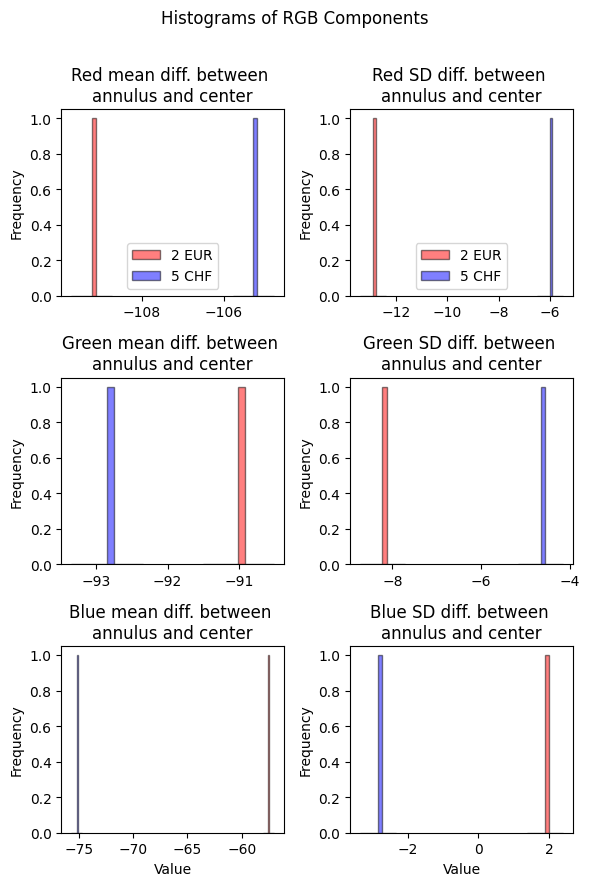

In [27]:
# Plotting
fig, axs = plt.subplots(3, 2, figsize=(6, 9), sharex=False)

# Red mean
axs[0,0].hist(mean_red_diff_2eur, bins=10, alpha=0.5, color='red', edgecolor='black', label='2 EUR')
axs[0,0].hist(mean_red_diff_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black', label='5 CHF')
axs[0,0].set_title('Red mean diff. between \nannulus and center')
axs[0,0].set_ylabel('Frequency')
axs[0,0].legend()

# Green mean
axs[1,0].hist(mean_green_diff_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[1,0].hist(mean_green_diff_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[1,0].set_title('Green mean diff. between \nannulus and center')
axs[1,0].set_ylabel('Frequency')

# Blue mean
axs[2,0].hist(mean_blue_diff_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[2,0].hist(mean_blue_diff_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[2,0].set_title('Blue mean diff. between \nannulus and center')
axs[2,0].set_xlabel('Value')
axs[2,0].set_ylabel('Frequency')

# Red SD
axs[0,1].hist(sd_red_diff_2eur, bins=10, alpha=0.5, color='red', edgecolor='black', label='2 EUR')
axs[0,1].hist(sd_red_diff_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black', label='5 CHF')
axs[0,1].set_title('Red SD diff. between \nannulus and center')
axs[0,1].set_ylabel('Frequency')
axs[0,1].legend()
# Green SD
axs[1,1].hist(sd_green_diff_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[1,1].hist(sd_green_diff_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[1,1].set_title('Green SD diff. between \nannulus and center')
axs[1,1].set_ylabel('Frequency')

# Blue SD
axs[2,1].hist(sd_blue_diff_2eur, bins=10, alpha=0.5, color='red', edgecolor='black')
axs[2,1].hist(sd_blue_diff_5chf, bins=10, alpha=0.5, color='blue', edgecolor='black')
axs[2,1].set_title('Blue SD diff. between \nannulus and center')
axs[2,1].set_xlabel('Value')
axs[2,1].set_ylabel('Frequency')

# Main title
fig.suptitle('Histograms of RGB Components')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Show plot
plt.show()

# Classification: automated ML with FLAML

Now that the dataset is ready, we use the FLAML library to automatically find a quality model for our classification task.

## 1. Training

### 1.1 Splitting the dataset

In [64]:
from flaml import AutoML
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset.squeeze(), test_size=0.2, random_state=42)

### 1.2 FLAML settings

In [67]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 30,  # in seconds
    "metric": "accuracy",
    "task": "classification",
    "log_file_name": "classification.log",
    "seed": 42,
}

### 1.3 Fitting

In [66]:
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Predict
print(automl.predict_proba(X_train))

# Print the best model
print(automl.model.estimator)

TypeError: unhashable type: 'list'

## 2. Model evaluation

### 2.1 Best model and hyperparameters

In [46]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 46, 'num_leaves': 11, 'min_child_samples': 19, 'learning_rate': 0.2979422475152573, 'log_max_bin': 7, 'colsample_bytree': 0.8332275411263533, 'reg_alpha': 0.07968095401884977, 'reg_lambda': 0.36186216876175514}
Best accuracy on validation data: 0.8248
Training duration of best run: 0.1226 s


In [47]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.8332275411263533,
               learning_rate=0.2979422475152573, max_bin=127,
               min_child_samples=19, n_estimators=1, n_jobs=-1, num_leaves=11,
               reg_alpha=0.07968095401884977, reg_lambda=0.36186216876175514,
               verbose=-1)

In [48]:
from flaml.automl.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 462, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 462, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 6, 'min_child_samples': 24, 'learning_rate': 0.15080280060326612, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.04561250779031766}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 6, 'min_child_samples': 24, 'learning_rate': 0.15080280060326612, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.

### 2.2 Learning curve

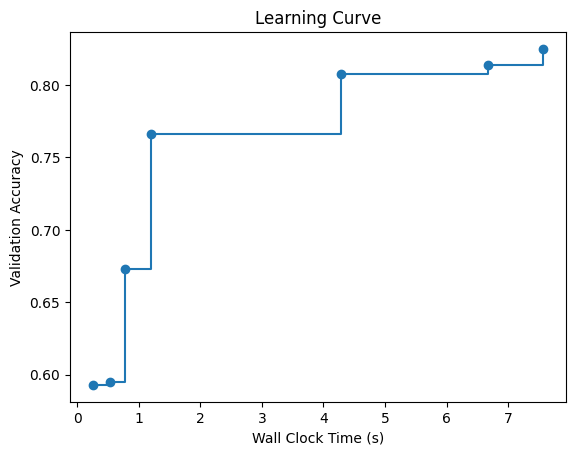

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 2.3 Prediction accuracy with the trained model

In [68]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

[flaml.automl.logger: 05-28 13:19:18] {572} WARNING - No estimator is trained. Please run fit with enough budget.
Predicted labels None
True labels 1    7
Name: label, dtype: int64
[flaml.automl.logger: 05-28 13:19:18] {599} WARNING - No estimator is trained. Please run fit with enough budget.


TypeError: 'NoneType' object is not subscriptable

In [51]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
#print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
#print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.5194805194805194
